In [1]:
import pandas as pd
from nltk import word_tokenize as tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support
import torch
import torch.nn as nn
import numpy as np

In [2]:
df = pd.read_csv("/kaggle/input/training/propaganda_train.tsv",sep="\t")
df

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
...,...,...
2409,not_propaganda,<BOS> We support and appreciate <EOS> your bus...
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...
2411,not_propaganda,What has been done: there has been work on for...
2412,not_propaganda,This is <BOS> the law of gradualness not the g...


In [3]:
df_val_data = pd.read_csv("/kaggle/input/training/propaganda_val.tsv",sep="\t")
df_val_data

,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...
...,...,...
575,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E..."
576,not_propaganda,"Remember our saying, modern day fairy <BOS> ta..."
577,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...
578,flag_waving,<BOS> He also sang an Islamic State fight song...


In [4]:
df = pd.concat([df,df_val_data])
df # We concatenated two dataframes that we are going to use for our problem.

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
...,...,...
575,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E..."
576,not_propaganda,"Remember our saying, modern day fairy <BOS> ta..."
577,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...
578,flag_waving,<BOS> He also sang an Islamic State fight song...


In [5]:
df_task_2 = pd.read_csv("/kaggle/input/training/propaganda_train.tsv",sep="\t")
df_task_2

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
...,...,...
2409,not_propaganda,<BOS> We support and appreciate <EOS> your bus...
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...
2411,not_propaganda,What has been done: there has been work on for...
2412,not_propaganda,This is <BOS> the law of gradualness not the g...


In [6]:
df_task_2 = pd.concat([df_task_2,df_val_data])
df_task_2 # We concatenated two dataframes that we are going to use for our problem.

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
...,...,...
575,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E..."
576,not_propaganda,"Remember our saying, modern day fairy <BOS> ta..."
577,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...
578,flag_waving,<BOS> He also sang an Islamic State fight song...


In [7]:
for i, row in df_task_2.iterrows():
    texts = row[-1]
    texts = texts.split("<BOS>")[-1].split("<EOS>")[0]
    #print(texts)
    df_task_2.at[i,"tagged_in_context"] = texts

/tmp/ipykernel_34/3967616072.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts = row[-1]


In [8]:
df_task_2.head()

,label,tagged_in_context
0,not_propaganda,he
1,not_propaganda,won’t make things any worse than they are for...
2,flag_waving,American people
3,not_propaganda,and
4,not_propaganda,"Location: Westerville, Ohio"


In [9]:
for i, row in df.iterrows():
    val = ""
    if df.iloc[i]["label"] != "not_propaganda":
        val = "propaganda"
    else:
        val = "not_propaganda"
    df.at[i,"label"] = val

# NAIVE BAYES CLASSIFIER FOR TASK 1

The code for naive bayes classifier is available at https://www.kaggle.com/code/ankumagawa/sentimental-analysis-using-naive-bayes-classifier#4.5.-Navies-Bayes-Modelling:

In [10]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
import re

def remove_tags(string):
    removelist = ""
    result = re.sub('','',string)          #remove HTML tags
    result = re.sub('https://.*','',result)   #remove URLs
    #result = re.sub(r'[^w'+removelist+']', ' ',result)    #remove non-alphanumeric characters
    result = result.lower()
    return result
df['tagged_in_context']=df['tagged_in_context'].apply(lambda cw : remove_tags(cw))

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['tagged_in_context'] = df['tagged_in_context'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
from sklearn.preprocessing import LabelEncoder

propaganda = df['label'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(propaganda)


In [13]:
# def laplace_smoothing(n_label_items, vocab, word_counts, word, text_label):
#     a = word_counts[text_label][word] + 1
#     b = n_label_items[text_label] + len(vocab)
#     return math.log(a/b)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df['tagged_in_context'])
text_counts

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<2994x9271 sparse matrix of type '<class 'numpy.int64'>'
	with 45890 stored elements in Compressed Sparse Row format>

In [15]:
from sklearn.model_selection import train_test_split
X=text_counts
y=df['label']
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5,random_state=42)

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

metric_values = {}

MNB = MultinomialNB()
MNB.fit(X_train, y_train)

predicted = MNB.predict(X_val)
accuracy_score = accuracy_score(predicted, y_val)

other_met = list(precision_recall_fscore_support(y_val, predicted, average='weighted'))
metric_values["multinomial_nb"] =  [accuracy_score] + other_met[:-1]
metric_values["multinomial_nb"]

[0.6655518394648829, 0.6771870061993734, 0.6655518394648829, 0.667083113025103]

In [17]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix
CNB = ComplementNB()
CNB.fit(X_train, y_train)

from sklearn import metrics
predicted = CNB.predict(X_val)
accuracy_score = metrics.accuracy_score(predicted, y_val)
accuracy_score

other_met = list(precision_recall_fscore_support(y_val, predicted, average='weighted'))
metric_values["competent_nb"] =  [accuracy_score] + other_met[:-1]
metric_values["competent_nb"]

[0.6655518394648829, 0.6771870061993734, 0.6655518394648829, 0.667083113025103]

In [18]:
from sklearn.naive_bayes import BernoulliNB

BNB = BernoulliNB()
BNB.fit(X_train, y_train)

predicted = BNB.predict(X_val)
accuracy_score_bnb = metrics.accuracy_score(predicted,y_val)
accuracy_score_bnb

other_met = list(precision_recall_fscore_support(y_val, predicted, average='weighted'))
metric_values["bernouli_nb"] =  [accuracy_score] + other_met[:-1]
metric_values["bernouli_nb"]

[0.6655518394648829, 0.7080653460252122, 0.6521739130434783, 0.645709181094773]

In [19]:
predicted = CNB.predict(X_test)
accuracy_score_bnb = metrics.accuracy_score(predicted,y_test)
accuracy_score_bnb

other_met = list(precision_recall_fscore_support(y_test, predicted, average='weighted'))
metric_values["competent_nb"] =  [accuracy_score] + other_met[:-1]
metric_values["competent_nb"]

[0.6655518394648829, 0.5944591169801253, 0.5933333333333334, 0.593659188034188]

In [20]:
predicted = BNB.predict(X_test)
accuracy_score_bnb = metrics.accuracy_score(predicted,y_test)
accuracy_score_bnb

other_met = list(precision_recall_fscore_support(y_test, predicted, average='weighted'))
metric_values["bernouli_nb"] =  [accuracy_score] + other_met[:-1]
metric_values["bernouli_nb"]

[0.6655518394648829,
 0.6316124117617186,
 0.6266666666666667,
 0.6148456288592785]

In [21]:
predicted = MNB.predict(X_test)
accuracy_score_bnb = metrics.accuracy_score(predicted,y_test)
accuracy_score_bnb

other_met = list(precision_recall_fscore_support(y_test, predicted, average='weighted'))
metric_values["multinomial_nb"] =  [accuracy_score] + other_met[:-1]
metric_values["multinomial_nb"]

[0.6655518394648829, 0.5944591169801253, 0.5933333333333334, 0.593659188034188]

We get the results for the training data. We are now going to examine our model on test data.

# BERT CLASSIFIER FOR TASK 1

The code for bert classifier is available at https://www.kaggle.com/code/joydeb28/text-classification-with-bert-pytorch/notebook

In [22]:
value_counts = {}
for vals in df_task_2["label"].unique():
  value_counts[vals] = value_counts.get(vals,0) + len(df_task_2[df_task_2["label"] == vals])

value_counts

{'not_propaganda': 1492,
 'flag_waving': 187,
 'loaded_language': 191,
 'doubt': 182,
 'name_calling,labeling': 188,
 'appeal_to_fear_prejudice': 194,
 'repetition': 179,
 'causal_oversimplification': 189,
 'exaggeration,minimisation': 192}

<BarContainer object of 9 artists>

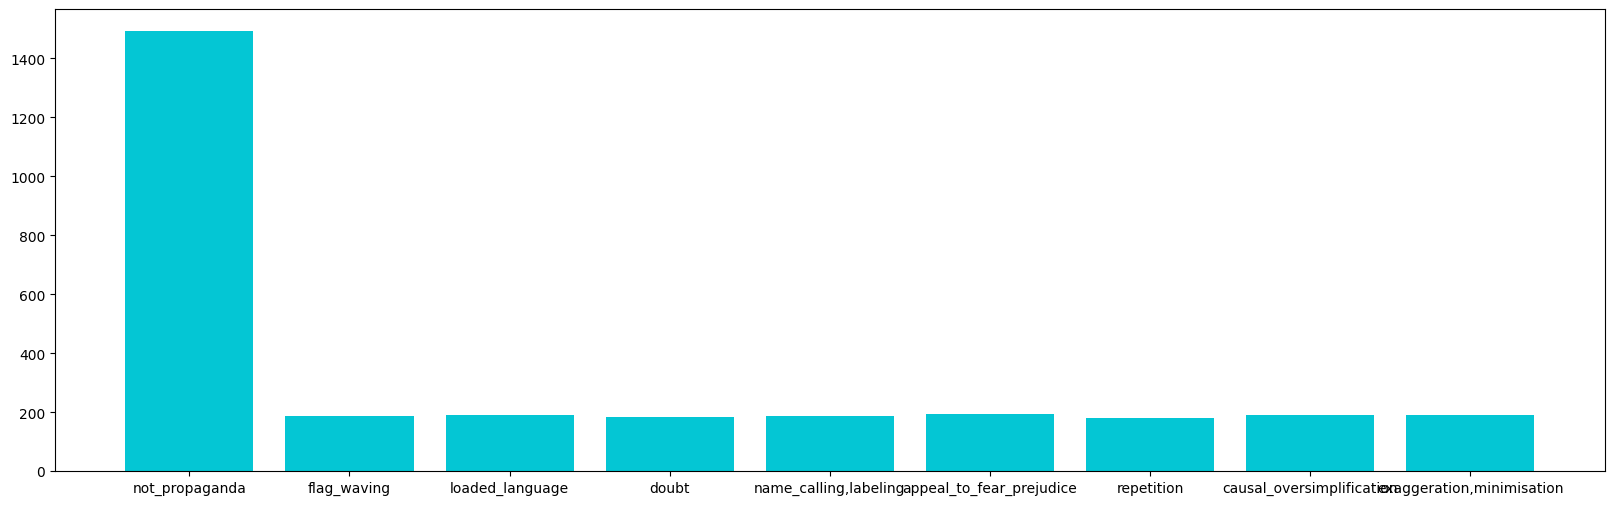

In [23]:
plt.figure(figsize = (20,6))
plt.bar(value_counts.keys(),value_counts.values(),color = "#04c6d4")
# As we can see from the bar chart the distribution of classes are even hence this model represents the use case well.

In [24]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [25]:
x_train, x_val_test, y_train, y_val_test = train_test_split(df['tagged_in_context'], df['label'],
                                                                    random_state=42,
                                                                    test_size=0.2)
#stratify=train_df['category']

x_val, x_test, y_val, y_test = train_test_split(x_val_test,y_val_test,random_state=42,test_size=0.2)

788


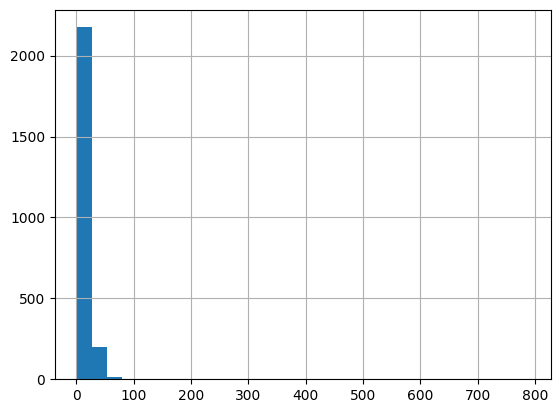

In [26]:
seq_len = [len(i.split()) for i in x_train]

pd.Series(seq_len).hist(bins = 30)
max_seq_len = max(seq_len)
print(max_seq_len)

In [27]:
if max_seq_len>512:
    max_seq_len = 512
tokens_train = tokenizer.batch_encode_plus(
    x_train.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    x_val.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


tokens_test = tokenizer.batch_encode_plus(
    x_test.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [28]:
# a temporary list to store the string labels
temp_list = y_train.tolist()

# dictionary that maps integer to its string value
label_dict = {}

# list to store integer labels
int_labels = []

for i in range(len(temp_list)):
    label_dict[i] = temp_list[i]
    int_labels.append(i)


# a temporary list to store the string labels
temp_list_val = y_val.tolist()

# dictionary that maps integer to its string value
label_dict_val = {}

# list to store integer labels
int_labels_val = []

for i in range(len(temp_list_val)):
    label_dict_val[i] = temp_list_val[i]
    int_labels_val.append(i)

In [29]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(int_labels)
print("train_y:",train_y)
# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(int_labels_val)
print("val_y:",val_y)

train_y: tensor([   0,    1,    2,  ..., 2392, 2393, 2394])
val_y: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 16

In [30]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [31]:
class BERT_Propaganda(nn.Module):
    def __init__(self, bert,label_map):
        super(BERT_Propaganda, self).__init__()
        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,len(label_map))

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

        #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)
        return x

In [32]:
bert = BertModel.from_pretrained("bert-base-uncased")
# pass the pre-trained BERT to our define architecture
label_map = {"not_propaganda":0,"propaganda":1}
model = BERT_Propaganda(bert,label_map)
device = torch.device("cuda")
# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

print(class_wts)

[0.99791667 1.00209205]


In [36]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 30

In [37]:
def train():
    model.train()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
    total_labels =[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
        # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        # append the model predictions
        total_preds+=list(preds)
        total_labels+=labels.tolist()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
    f1 = f1_score(total_labels, total_preds, average='weighted')
    #returns the loss and predictions
    return avg_loss, f1

In [38]:
def evaluate():
  
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

          # Calculate elapsed time in minutes.
          #elapsed = format_time(time.time() - t0)

          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            total_preds+=list(preds)
            total_labels+=labels.tolist()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
    
    f1 = f1_score(total_labels, total_preds, average='weighted')
    return avg_loss, f1

In [39]:
def save_checkpoint(filename, epoch, model, optimizer, label_map, id2label):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer,
        'label_map': label_map,
        'id_map':id2label}
    torch.save(state, filename)

In [40]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, f1_train = train()
    
    #evaluate model
    valid_loss, f1_valid = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        file_name = 'topic_saved_weights.pt'
        save_checkpoint(file_name, epoch, model, optimizer, label_map, id2label)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'\nTraining F1: {f1_train:.3f}')
    print(f'Validation F1: {f1_valid:.3f}')


 Epoch 1 / 30


TypeError: linear(): argument 'input' (position 1) must be Tensor, not str

In [ ]:
path = 'topic_saved_weights.pt'
test_df = ld.validation_data_frame

checkpoint = torch.load(path,map_location=device)
model = checkpoint.get("model")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# tokenize and encode sequences in the test set
test_text,test_labels = test_df["query"],test_df["category"]

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())
print("test_y:",test_y)

# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
    
    
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
class Prediction:
    def __init__(self):
        path = 'topic_saved_weights.pt'

        checkpoint = torch.load(path,map_location=device)
        self.predictor = checkpoint.get("model")
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.tag = checkpoint.get("id_map")

    def predict(self,text):
        tokens = self.tokenizer.tokenize(text)
        tokens = tokens[:max_seq_len - 2]
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ids = input_ids + [0] * (max_seq_len-len(input_ids))
        input_ids = torch.tensor(input_ids).unsqueeze(0)
        input_ids = input_ids.to(device)

        input_mask = [1]*len(tokens) + [0] * (max_seq_len - len(tokens))
        input_mask = torch.tensor(input_mask).unsqueeze(0)
        input_mask = input_mask.to(device)

        logits = self.predictor(input_ids,input_mask)
        prob = torch.nn.functional.softmax(logits,dim=1)
        result = [(self.tag[idx],item *100) for idx,item in enumerate(prob[0].tolist())]
        preds = logits.detach().cpu().numpy()
        pred_val = np.argmax(preds)
        pred_val = self.tag[pred_val]
        return result,pred_val
    
pred = Prediction()

# NAIVE BAYES CLASSIFIER FOR TASK 2

In [41]:
df_task_2['tagged_in_context']=df_task_2['tagged_in_context'].apply(lambda cw : remove_tags(cw))
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df_task_2['tagged_in_context'] = df_task_2['tagged_in_context'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

propaganda = df_task_2['label'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(propaganda)

cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df_task_2['tagged_in_context'])

X=text_counts
y=df_task_2['label']

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5,random_state=42)

from sklearn.metrics import accuracy_score

MNB.fit(X_train, y_train)
CNB.fit(X_train, y_train)
BNB.fit(X_train, y_train)

predicted = MNB.predict(X_val)
accuracy_score = accuracy_score(predicted, y_val)

other_met = list(precision_recall_fscore_support(y_val, predicted, average='weighted'))
metric_values["mb_t2"] =  [accuracy_score] + other_met[:-1]
print(metric_values["mb_t2"])

predicted = CNB.predict(X_val)
accuracy_score = metrics.accuracy_score(predicted, y_val)

other_met = list(precision_recall_fscore_support(y_val, predicted, average='weighted'))
metric_values["cb_t2"] =  [accuracy_score] + other_met[:-1]
print(metric_values["cb_t2"])


predicted = BNB.predict(X_val)
accuracy_score = metrics.accuracy_score(predicted, y_val)


other_met = list(precision_recall_fscore_support(y_val, predicted, average='weighted'))
metric_values["bn_t2"] =  [accuracy_score] + other_met[:-1]
print(metric_values["bn_t2"])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[0.4682274247491639, 0.32866814111554643, 0.4682274247491639, 0.3612678625722104]
[0.30434782608695654, 0.3910720632813029, 0.30434782608695654, 0.33173285789850815]
[0.46153846153846156, 0.3471917887210241, 0.46153846153846156, 0.3067862241646365]


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

other_met = list(precision_recall_fscore_support(y_test, predicted, average='weighted'))
metric_values["mb_t2"] =  [accuracy_score] + other_met[:-1]
print(metric_values["mb_t2"])

predicted = CNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

other_met = list(precision_recall_fscore_support(y_test, predicted, average='weighted'))
metric_values["cb_t2"] =  [accuracy_score] + other_met[:-1]
print(metric_values["cb_t2"])


predicted = BNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)


other_met = list(precision_recall_fscore_support(y_test, predicted, average='weighted'))
metric_values["bn_t2"] =  [accuracy_score] + other_met[:-1]
print(metric_values["bn_t2"])

[0.48333333333333334, 0.34817605497483545, 0.48333333333333334, 0.3817546612613964]
[0.29, 0.37176356128921834, 0.29, 0.31395921590612674]
[0.49, 0.24583617747440276, 0.49, 0.3274090909090909]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
